<a href="https://colab.research.google.com/github/jgamel/learn_n_dev/blob/python_machine_learning/Neural_Network_Keras_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Example

Steps:

1. Haberman Breast Cancer Survival Dataset
2. Neural Network Learning Dynamics
3. Robust Model Evaluation
4. Final Model and Make Predictions

### Step 1: Load Data and Prep

Haberman Breast Cancer Survival Dataset
The first step is to define and explore the dataset.

We will be working with the “haberman” standard binary classification dataset.

The dataset describes breast cancer patient data and the outcome is patient survival. Specifically whether the patient survived for five years or longer, or whether the patient did not survive.

This is a standard dataset used in the study of imbalanced classification. According to the dataset description, the operations were conducted between 1958 and 1970 at the University of Chicago’s Billings Hospital.

There are 306 examples in the dataset, and there are 3 input variables; they are:

The age of the patient at the time of the operation.
The two-digit year of the operation.
The number of “positive axillary nodes” detected, a measure of whether cancer has spread.
As such, we have no control over the selection of cases that make up the dataset or features to use in those cases, other than what is available in the dataset.

Although the dataset describes breast cancer patient survival, given the small dataset size and the fact the data is based on breast cancer diagnosis and operations many decades ago, any models built on this dataset are not expected to generalize.

In [7]:
# load the haberman dataset and summarize the shape
from pandas import read_csv
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
# load the dataset
df = read_csv(url, header=None)
# summarize shape
print(df.shape)

(306, 4)


Running the example loads the dataset directly from the URL and reports the shape of the dataset.

In this case, we can confirm that the dataset has 4 variables (3 input and one output) and that the dataset has 306 rows of data.

This is not many rows of data for a neural network and suggests that a small network, perhaps with regularization, would be appropriate.

It also suggests that using k-fold cross-validation would be a good idea given that it will give a more reliable estimate of model performance than a train/test split and because a single model will fit in seconds instead of hours or days with the largest datasets.

Next, we can learn more about the dataset by looking at summary statistics and a plot of the data.

                0           1           2           3
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000


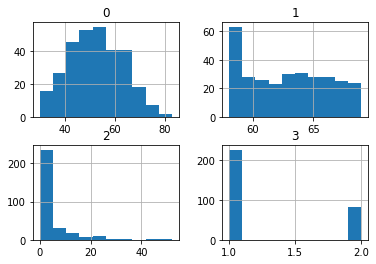

In [8]:
# show summary statistics and plots of the haberman dataset
from pandas import read_csv
from matplotlib import pyplot
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
# load the dataset
df = read_csv(url, header=None)
# show summary statistics
print(df.describe())
# plot histograms
df.hist()
pyplot.show()

Running the example first loads the data before and then prints summary statistics for each variable.

We can see that values vary with different means and standard deviations, perhaps some normalization or standardization would be required prior to modeling.

A histogram plot is then created for each variable.

We can see that perhaps the first variable has a Gaussian-like distribution and the next two input variables may have an exponential distribution.

We may have some benefit in using a power transform on each variable in order to make the probability distribution less skewed which will likely improve model performance.

We can see some skew in the distribution of examples between the two classes, meaning that the classification problem is not balanced. It is imbalanced.

It may be helpful to know how imbalanced the dataset actually is.

We can use the Counter object to count the number of examples in each class, then use those counts to summarize the distribution.

The complete example is listed below.

In [9]:
# summarize the class ratio of the haberman dataset
from pandas import read_csv
from collections import Counter
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
# define the dataset column names
columns = ['age', 'year', 'nodes', 'class']
# load the csv file as a data frame
dataframe = read_csv(url, header=None, names=columns)
# summarize the class distribution
target = dataframe['class'].values
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


We can see that class 1 for survival has the most examples at 225, or about 74 percent of the dataset. We can see class 2 for non-survival has fewer examples at 81, or about 26 percent of the dataset.

The class distribution is skewed, but it is not severely imbalanced.

This is helpful because if we use classification accuracy, then any model that achieves an accuracy less than about 73.5% does not have skill on this dataset.

Now that we are familiar with the dataset, let’s explore how we might develop a neural network model.

### Neural Network Learning Dynamics

We will develop a **Multilayer Perceptron (MLP) model** for the dataset using TensorFlow.

We cannot know what model architecture of learning hyperparameters would be good or best for this dataset, so we must experiment and discover what works well.

Given that the dataset is small, a small batch size is probably a good idea, e.g. 16 or 32 rows. Using the Adam version of stochastic gradient descent is a good idea when getting started as it will automatically adapt the learning rate and works well on most datasets.

Before we evaluate models in earnest, it is a good idea to review the learning dynamics and tune the model architecture and learning configuration until we have stable learning dynamics, then look at getting the most out of the model.

We can do this by using a simple train/test split of the data and review plots of the learning curves. This will help us see if we are over-learning or under-learning; then we can adapt the configuration accordingly.

First, we must ensure all input variables are floating-point values and encode the target label as integer values 0 and 1.

In [10]:
# fit a simple mlp model on the haberman and review learning curves
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
# load the dataset
path = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
# ensure all data are floating point values
X = X.astype('float32')
# encode strings to integer
y = LabelEncoder().fit_transform(y)

Next, we can split the dataset into input and output variables, then into 67/33 train and test sets.

We must ensure that the split is stratified by the class ensuring that the train and test sets have the same distribution of class labels as the main dataset.

In [11]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=3)

We can define a minimal MLP model. In this case, we will use one hidden layer with 10 nodes and one output layer (chosen arbitrarily). We will use the ReLU activation function in the hidden layer and the “he_normal” weight initialization, as together, they are a good practice.

The output of the model is a sigmoid activation for binary classification and we will minimize binary cross-entropy loss.

In [12]:
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

We will fit the model for 200 training epochs (chosen arbitrarily) with a batch size of 16 because it is a small dataset.

We are fitting the model on raw data, which we think might be a good idea, but it is an important starting point.

In [13]:
# fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,y_test))

At the end of training, we will evaluate the model’s performance on the test dataset and report performance as the classification accuracy.

In [14]:
import numpy as np
# predict test set
yhat = (model.predict(X_test) > 0.5).astype("int32")
# yhat = np.argmax(model.predict(X_test), axis=-1)
# yhat = model.predict_classes(X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.752


Finally, we will plot learning curves of the cross-entropy loss on the train and test sets during training.

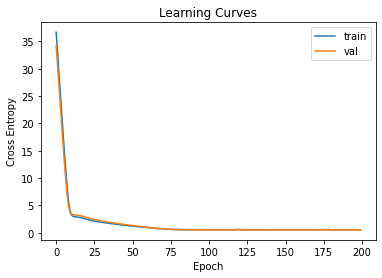

In [15]:
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Running the example first fits the model on the training dataset, then reports the classification accuracy on the test dataset.

Line plots of the loss on the train and test sets are then created.

We can see that the model quickly finds a good fit on the dataset and does not appear to be over or underfitting.

Now that we have some idea of the learning dynamics for a simple MLP model on the dataset, we can look at developing a more robust evaluation of model performance on the dataset.

### Robust Model Evaluation

The k-fold cross-validation procedure can provide a more reliable estimate of MLP performance, although it can be very slow.

This is because k models must be fit and evaluated. This is not a problem when the dataset size is small, such as the cancer survival dataset.

We can use the StratifiedKFold class and enumerate each fold manually, fit the model, evaluate it, and then report the mean of the evaluation scores at the end of the procedure.

In [16]:
# k-fold cross-validation of base model for the haberman dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
# load the dataset
path = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
# ensure all data are floating point values
X = X.astype('float32')
# encode strings to integer
y = LabelEncoder().fit_transform(y)
# prepare cross validation
kfold = StratifiedKFold(10, random_state=1, shuffle=True)
# enumerate splits
scores = list()
for train_ix, test_ix in kfold.split(X, y):
	# split data
	X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
	# determine the number of input features
	n_features = X.shape[1]
	# define model
	model = Sequential()
	model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
	model.add(Dense(1, activation='sigmoid'))
	# compile the model
	model.compile(optimizer='adam', loss='binary_crossentropy')
	# fit the model
	model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)
	# predict test set
	# yhat = np.argmax(model.predict(X_test), axis=-1)
	yhat = (model.predict(X_test) > 0.5).astype("int32")
  # evaluate predictions
	score = accuracy_score(y_test, yhat)
	print('>%.3f' % score)
	scores.append(score)
# summarize all scores
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

>0.710
>0.742
>0.774
>0.806
>0.710
>0.742
>0.833
>0.700
>0.667
>0.800
Mean Accuracy: 0.748 (0.051)


If you are using TensorFlow version 2.5, you will receive the following warning:

tensorflow\python\keras\engine\sequential.py:455: UserWarning: model.predict_classes() is deprecated and will be removed after 2021-01-01. Please use instead:* np.argmax(model.predict(x), axis=-1), if your model does multi-class classification (e.g. if it uses a softmax last-layer activation).* (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).

Is this a good result?

In fact, this is a challenging classification problem and achieving a score above about 74.5% is good.

Next, let’s look at how we might fit a final model and use it to make predictions.

### Final Model and Make Predictions

Once we choose a model configuration, we can train a final model on all available data and use it to make predictions on new data.

In this case, we will use the model with dropout and a small batch size as our final model.

We can prepare the data and fit the model as before, although on the entire dataset instead of a training subset of the dataset.

First, we can define a row of new data.

In [17]:
# define a row of new data
row = [30,64,1]

Note: I took this row from the first row of the dataset and the expected label is a ‘1’.

We can then make a prediction.

In [18]:
# make prediction
#yhat = model.predict_classes([row])
yhat = (model.predict([row]) > 0.5).astype("int32")

Then invert the transform on the prediction, so we can use or interpret the result in the correct label (which is just an integer for this dataset).

In [19]:
# fit a final model and make predictions on new data for the haberman dataset
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
# load the dataset
path = 'https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/haberman.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
# ensure all data are floating point values
X = X.astype('float32')
# encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
# fit the model
model.fit(X, y, epochs=200, batch_size=16, verbose=0)
# define a row of new data
row = [30,64,1]
# make prediction
yhat = (model.predict([row]) > 0.5).astype("int32")
# invert transform to get label for class
yhat = le.inverse_transform(yhat)
# report prediction
print('Predicted: %s' % (yhat[0]))

Predicted: 1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running the example fits the model on the entire dataset and makes a prediction for a single row of new data.

In this case, we can see that the model predicted a “1” label for the input row.